*title*: **C-VAE** Interpolation  
*author*: Tiago Ribeiro

In [ ]:
from watermark import watermark
import tensorflow as tf
print(watermark(author="\033[1m" +"Tiago F. R. Ribeiro" + "\033[0m", 
                github_username="\033[1m" +"Tiago1Ribeiro"+ "\033[0m", 
                current_date=True, datename=False, iso8601=False, current_time=True, 
                timezone=False, python=True, conda=True, machine=True, updated=True,
                iversions=True,  globals_= globals()))
gpu = !nvidia-smi --query-gpu=gpu_name --format=csv,noheader
cuda = !nvcc --version | grep release | cut -d ' ' -f 5 | cut -d ',' -f 1

### Setup

In [9]:
#~ General imports ~
import numpy as np
import os
from glob import glob
from tqdm import tqdm
import datetime
import cv2
import re
import matplotlib.pyplot as plt
from matplotlib.image import imsave
import warnings
warnings.filterwarnings('ignore')

#~ geospatial and raster manipulation imports ~
from shapely import wkt                     
from shapely.geometry import shape, MultiPolygon
from rasterio.features import shapes
from rasterio import Affine

#~ Neural Network related imports and configurations ~
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Activation, Dense, Lambda, Input 
from tensorflow.keras.layers import MaxPooling2D, Flatten, Reshape, Concatenate
from tensorflow.keras.layers import SeparableConv2D, Conv2DTranspose
from tensorflow.keras import backend as K 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

### C-VAE Configs

In [10]:
ARGS = dict(
    IMG_SIZE = (512, 512),
    BATCH_SZ = 2,
    REF_FILTERS = 32,
    F_INIT = "he_normal",
    OPTIMIZER = tf.keras.optimizers.Adam(learning_rate = 3e-4),
    COST_F = tf.keras.losses.MeanSquaredError(),
    CONV_ACTIV = tf.keras.layers.Activation(tf.nn.leaky_relu),
    SEED = 42,
    LATENT_DIM = 64,
    DTYPE = tf.float32
)

### Auxiliary functions

#### plot_learning_curves

In [11]:
# function to show learning curves plot
def plot_learning_curves(history):

    # figure size in inches optional
    plt.figure(figsize=(15, 6))
    plt.title("Learning Curves")
    plt.grid(True, linestyle='-.', linewidth=0.3)
    plt.xticks(np.arange(0, max(history.epoch)+50, 50))
    # y axis in scientific notation and log scale, showing every 5th label
    # plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0), useMathText=True)
    plt.yscale('log')
    plt.yticks(np.arange(0, max(history.history['loss']), 0.1), fontsize=8)
    plt.xticks(fontsize=8)
    # plot the loss with thin line
    plt.plot(history.history['loss'], label='train loss', linewidth=0.7)
    # plot the validation loss with thin line and other color
    plt.plot(history.history['val_loss'], label='test loss', linewidth=0.7)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    # find on which epoch the loss is minimum and add a point to the plot
    min_loss = min(history.history['loss'])
    min_loss_epoch = history.history['loss'].index(min_loss)
    plt.plot(min_loss_epoch, min_loss, marker='o', markersize=2, color="red")
    # add text in gray color with small arrow to the point in scientific notation 
    plt.annotate("min: {:.2e}".format(min_loss), xy=(min_loss_epoch, min_loss), 
                xytext=(min_loss_epoch+10, min_loss+0.01),fontsize=7, 
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    # find on which epoch the validation loss is minimum and add a green point to the plot
    min_val_loss = min(history.history['val_loss'])
    min_val_loss_epoch = history.history['val_loss'].index(min_val_loss)
    plt.plot(min_val_loss_epoch, min_val_loss, marker='o', markersize=2, color="red")
    # add text in gray color with small arrow to the point in scientific notation
    plt.annotate("min: {:.2e}".format(min_val_loss), xy=(min_val_loss_epoch, min_val_loss),
                xytext=(min_val_loss_epoch+10, min_val_loss+0.01),fontsize=7,
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
                
    # if ReduceOnPlateau callback is used, add a vertical line and a 
    # text for each change in learning rate
    if 'lr' in history.history.keys():
        # find the learning rate changes
        lr_changes = []
        for i in range(len(history.history['lr'])):
            if history.history['lr'][i] != history.history['lr'][i-1]:
                lr_changes.append(i)
        # add a vertical line and a text for each change in learning rate
        for i in lr_changes:
            plt.axvline(x=i, color='mediumseagreen', linestyle='--', linewidth=0.7)
            plt.text(i+5, min(history.history['loss']) + 0.03, f"l.r.: {history.history['lr'][i]:.0e}", 
            fontsize=7, color='black', rotation=90)
plt.show()

####  wkt2masc

In [13]:
def wkt2masc(wkt_file, images_path, orig_dims, height, width):
    """ 
    Converts WKT files to segmentation masks.
    Parameters:
        wkt_file {str} -- path to the WKT file
        images_path {str} -- path to the folder where the masks will be saved
        orig_dims {tuple} -- original dimensions of the masks
        height {int} -- desired height of the masks
        width {int} -- desired width of the masks
    Returns:
        Creates PNG images of the masks
    """

    os.makedirs(images_path, exist_ok=True)

    # delete files in the folder, if any
    for filename in os.listdir(images_path):
        if filename.endswith(".png"):
            os.remove(os.path.join(images_path, filename))

    # open WKT file
    wkt = open(wkt_file, 'r')
    num_lines = len(wkt.readlines())
    cnt = 0
    
    print(f"""
    {'-'*38}
    # \033[1mProperties of the resulting masks\033[0m
    # Width: {width}, Height: {height}
    # Number of masks to create: {num_lines}
    {'-'*38}
    """)

    pbar = tqdm(total=num_lines)

    # process each line of the WKT file
    with open(wkt_file) as f:
        for line in f:
            # extract numbers from the line
            points = [int(s) for s in re.findall('[0-9]+', line)]
            # create empty mask
            mask = np.zeros(orig_dims, dtype=np.uint8)
            # create array with polygon points, with 2 columns (x,y)
            arr = np.array(points, dtype=np.int32).reshape((-1,2))
            # draw mask
            cv2.drawContours(image = mask,
                             contours=[arr],
                             contourIdx=-1,
                             color=(255, 255, 255),
                             thickness=-1,  # if > 0, thickness of the contour; if -1, fill object
                             lineType=cv2.LINE_AA)
            # resize frames with Lanczos interpolation
            mask_resized = cv2.resize(mask, (width, height), interpolation=cv2.INTER_LANCZOS4)
            # save mask and 
            cv2.imwrite(os.path.join(images_path, f"mask_{cnt:06d}.png"), mask_resized)
            cnt += 1
            pbar.update(1)

    pbar.close()

#### load_images_from_folder

In [14]:
def load_images_from_folder(folder_path, target_size=(256,256)):
    images = list()
    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):
            # Load the image and convert it to a Numpy array
            img = load_img(os.path.join(folder_path, filename), target_size)
            img_array = img_to_array(img) / 255.0  # rescale pixel values to [0,1]
            # Add the image array to the list of images
            images.append(img_array)
    # Convert the list of images to a float32 Numpy array
    images_array = np.array(images).astype("float32")
    
    return images_array

#### frame_to_label

In [15]:
def frame_to_label(frame):
    label = np.float32(frame /22500)
    label = np.expand_dims(label, axis=0)
    return label

#### msks_paths_to_polygon_list

In [16]:
def msks_paths_to_polygon_list(msks_paths, out_dim = (512, 512)):
    """
    Converts segmentation masks paths list to list of shapely multipolygons.

    Parameters:
        msks_paths {list} -- list of paths to the masks
        out_dim {tuple} -- (width, height) desired dimensions of the masks 
    Returns:
        pol_list {list} -- list of shapely multipolygons
    """
    
    pol_list = list()
    for img_path in msks_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # image dimensions
        h, w = img.shape
        if (w, h) != out_dim:
            img = cv2.resize(img, out_dim, interpolation=cv2.INTER_CUBIC)
        polygon = mask_to_polygons(img)
        pol_list.append(polygon)
    return pol_list

#### mask_to_polygons

In [17]:
def mask_to_polygons(mask_img):
    """
    Converts segmentation mask to shapely multipolygon.
    Adapted from: https://rocreguant.com/convert-a-mask-into-a-polygon-for-images-using-shapely-and-rasterio/1786/
    """
    all_polygons = list()
    
    for shp, _ in shapes(source=mask_img.astype(np.uint8),
                         mask=(mask_img>0), 
                         transform=Affine(1.0, 0, 0, 0, 1.0, 0)):
        all_polygons.append(shape(shp))

    all_polygons = MultiPolygon(all_polygons)

    # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
    # need to keep it a Multipolygon throughout
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    
    return all_polygons

#### frame2video

In [18]:
def frames2video(img_list, nome_ficheiro='video', fps_ = 25, titulo: str = "", frame_num_text  = False, font_size: int = 1) -> None:
    """ 
    Converte lista de imagens em ficheiro AVI com a mesma resolucão da primeira 
    imagem da lista.
      Parametros: - lista de imagens PNG, TIFF, JPEG, BMP, WEBP, STK, LSM ou XCF
                  - nome do ficheiro do video
      Devolve: salva vídeo no diretório de execucão
    """
    # guarda dimensões da primeira imagem
    img = cv2.imread(img_list[0])
    height, width, _ = img.shape
    size = (width, height)
    num_frames =  len(img_list)

    img_array = list()
    for i in range(len(img_list)):
        img = cv2.imread(img_list[i])
        img_array.append(img)
        print(f"1. Appending frames {i+1}/{num_frames}", end="\r")
        
    print("2. Creating video writer...")
    video = cv2.VideoWriter(filename= nome_ficheiro + '.avi',
                            fourcc=cv2.VideoWriter_fourcc(*'mp4v'), fps = fps_,
                            frameSize=size)

    for i in range(len(img_array)):
        if frame_num_text:
            frame_number_text = f"frame_{i:06d}"
            cv2.putText(img_array[i], frame_number_text, (width-300, 50), 
                        cv2.FONT_HERSHEY_SIMPLEX,font_size, (255, 100, 100), 
                        2, cv2.LINE_AA)
        if titulo:
            cv2.putText(img_array[i], titulo, (50, 50), cv2.FONT_HERSHEY_SIMPLEX,
                        font_size, (255, 255, 255), 2, cv2.LINE_AA)
        
        video.write(img_array[i])
        print(f"3. Writing frames to file {i+1}/{num_frames}", end="\r")
    video.release()

### Data Sources

**note**: to test on your own machine, please set up the paths

In [20]:
DIR = os.getcwd()
IMG_DIR = os.path.normpath('E://BurnedAreaUAV_files//Results')
WKT_FILE = os.path.normpath("E://BurnedAreaUAV_files//BurnedAreaUAV_dataset//WKT_files//train_valid.wkt")
WKT_FILE_TEST = os.path.normpath("E://BurnedAreaUAV_files//BurnedAreaUAV_dataset//WKT_files//test.wkt")
# Sampled masks directory
DIR_SAMPLED = os.path.normpath("E:/BurnedAreaUAV_files/Interpolation/reference_masks")
TXT_FILE_SAMPLED = os.path.join(DIR_SAMPLED, "sampled_masks.txt")
WKT_FILE_SAMPLED = os.path.join(DIR_SAMPLED, "sampled_masks.wkt")
# Train, Test and Checkpoints directories
TRAIN_DIR = os.path.join(DIR, "train_masks")
TRAIN_SAMPLED_DIR = os.path.join(DIR, "sampled_masks")
os.makedirs(TRAIN_SAMPLED_DIR, exist_ok=True)
TEST_DIR = os.path.join(DIR, "test_masks")
os.makedirs(os.path.join(DIR, "checkpoints"), exist_ok=True)
CHCKPNT_MODELS = os.path.join(DIR, "checkpoints")
# Original dimensions of the images
ORIG_DIMS = (720, 1280)

wkt2masc(wkt_file=WKT_FILE, images_path=TRAIN_DIR, orig_dims=ORIG_DIMS, 
         height=ARGS["IMG_SIZE"][0], width=ARGS["IMG_SIZE"][1])

wkt2masc(wkt_file=WKT_FILE_TEST, images_path=TEST_DIR, orig_dims=ORIG_DIMS, 
         height=ARGS["IMG_SIZE"][0], width=ARGS["IMG_SIZE"][1])

# read txt file 
with open(TXT_FILE_SAMPLED, 'r') as f:
    polygons = f.readlines()
    # extract indexes and polygons
    indexes = [int(polygon.split(',')[0]) for polygon in polygons]
    polygons = [polygon.split(',', 1)[1][:-1] for polygon in polygons]

wkt2masc(wkt_file=WKT_FILE_SAMPLED, images_path=TRAIN_SAMPLED_DIR, orig_dims=ORIG_DIMS, 
         height=ARGS["IMG_SIZE"][0], width=ARGS["IMG_SIZE"][1])


    --------------------------------------
    # Properties of the resulting masks
    # Width: 512, Height: 512
    # Number of masks to create: 226
    --------------------------------------
    


100%|██████████| 226/226 [00:00<00:00, 505.63it/s]



    --------------------------------------
    # Properties of the resulting masks
    # Width: 512, Height: 512
    # Number of masks to create: 23
    --------------------------------------
    


100%|██████████| 23/23 [00:00<00:00, 518.43it/s]



    --------------------------------------
    # Properties of the resulting masks
    # Width: 512, Height: 512
    # Number of masks to create: 13
    --------------------------------------
    


100%|██████████| 13/13 [00:00<00:00, 543.11it/s]


### Data Loading and Preprocessing

#### Labels generation

In [11]:
msks_train_path = glob(os.path.join(TRAIN_DIR, "*.png"))
msks_train_basename = [os.path.basename(m) for m in msks_train_path]
msks_train_num = [int(m.split("_")[1].split(".")[0]) for m in msks_train_basename]
# mutiply masks number by 100 to get the same range as the frames
msks_train_labels = [m*100 for m in msks_train_num]

msks_test_path = glob(os.path.join(TEST_DIR, "*.png"))
msks_test_basename = [os.path.basename(m) for m in msks_test_path]
msks_test_num = [int(m.split("_")[1].split(".")[0]) for m in msks_test_basename]
# mutiply masks number by 100 to get the same range as the frames
msks_test_labels = [(m*100 + 20250) for m in msks_test_num]

In [19]:
# For Sampled masks only
msks_train_path = glob(os.path.join(TRAIN_SAMPLED_DIR, "*.png"))
msks_train_labels = [m*100 for m in indexes]
msks_test_path = glob(os.path.join(TEST_DIR, "*.png"))
msks_test_basename = [os.path.basename(m) for m in msks_test_path]
msks_test_num = [int(m.split("_")[1].split(".")[0]) for m in msks_test_basename]
# mutiply masks number by 100 to get the same range as the frames
msks_test_labels = [(m*100 + 20250) for m in msks_test_num]

#### Data Loading and formatting

In [107]:
# train_imgs = load_images_from_folder(TRAIN_DIR, target_size=ARGS["IMG_SIZE"])
# For Sampled masks only
train_imgs = load_images_from_folder(TRAIN_SAMPLED_DIR, target_size=ARGS["IMG_SIZE"])
test_imgs = load_images_from_folder(TEST_DIR, target_size=ARGS["IMG_SIZE"])
train_imgs = train_imgs.reshape((-1, ARGS["IMG_SIZE"][0]*ARGS["IMG_SIZE"][1]))
test_imgs = test_imgs.reshape((-1, ARGS["IMG_SIZE"][0]*ARGS["IMG_SIZE"][1]))
input_shape = (ARGS["IMG_SIZE"][0]*ARGS["IMG_SIZE"][1],)

max_val = np.max(msks_train_labels)
train_labels = (msks_train_labels/max_val).astype(np.float32)
train_labels = np.expand_dims(train_labels, axis=-1)

test_labels = (msks_test_labels/max_val).astype(np.float32)
test_labels = np.expand_dims(test_labels, axis=-1)

print(f"train_imgs.shape: {train_imgs.shape}, train_labels.shape: {train_labels.shape}")
print(f"test_imgs.shape: {test_imgs.shape}, test_labels.shape: {test_labels.shape}")

train_imgs.shape: (13, 262144), train_labels.shape: (13, 1)
test_imgs.shape: (23, 262144), test_labels.shape: (23, 1)


### C-VAE Model

##### sampler layer

In [22]:
def sampler(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

##### conv_block

In [23]:
def conv_block(input, filters, f_init="he_normal"):
    """
    Apply two convolutional layers with ReLU activation function.

    Args:
        input (tensor): Input tensor to the block.
        filters (int): Number of filters in the convolutional layers.

    Returns:
        tensor: Output tensor of the block with ReLU activation.
    """
    x = SeparableConv2D(filters, 
                        kernel_size = (4,4), 
                        depthwise_initializer = f_init,
                        pointwise_initializer = f_init,
                        padding="same")(input)
    x = Activation(tf.nn.leaky_relu)(x)

    x = SeparableConv2D(filters, 
                        kernel_size = (4,4), 
                        depthwise_initializer = f_init,
                        pointwise_initializer = f_init,
                        padding="same")(x)
    ativ = Activation(tf.nn.leaky_relu)(x)

    m_pool = MaxPooling2D(pool_size=(2, 2),
                          strides=2,
                          data_format="channels_last",
                          padding='same')(ativ)
    
    return m_pool

##### deconv_block

In [24]:
def deconv_block(input, filters, f_init="he_normal"):
   """
   Apply two convolutional layers with ReLU activation function.

   Args:
         input (tensor): Input tensor to the block.
         filters (int): Number of filters in the convolutional layers.
        
   Returns:
         tensor: Output tensor of the block with ReLU activation.
   """   
   x = Conv2DTranspose(filters, 
                     kernel_size = (4,4), 
                     strides=2,
                     kernel_initializer = f_init,
                     data_format = "channels_last", 
                     padding="same")(input)

   x = SeparableConv2D(filters, 
                     kernel_size = (4,4), 
                     depthwise_initializer = f_init,
                     pointwise_initializer = f_init,
                     padding="same")(x)
   x = Activation(tf.nn.leaky_relu)(x)

   x = SeparableConv2D(filters, 
                     kernel_size = (4,4), 
                     depthwise_initializer = f_init,
                     pointwise_initializer = f_init,
                     padding="same")(x)
   activation = Activation(tf.nn.leaky_relu)(x)
   
   return activation

#### Sampling Layer

In [76]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def __init__(self, z_mean, z_log_var):
        super(Sampling, self).__init__()
        self.z_mean = z_mean
        self.z_log_var = z_log_var


    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'z_mean': self.z_mean,
            'z_log_var': self.z_log_var,
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

#### Model construction

Model: "cvae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 262144)]     0           []                               
                                                                                                  
 encoder (Functional)           [(None, 64),         33572816    ['input_8[0][0]']                
                                 (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                                  
 label (InputLayer)             [(None, 1)]          0           []                               
                                                                                               

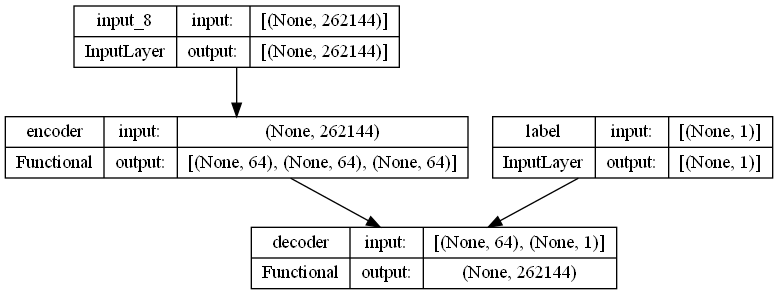

In [87]:
INPUT_SHAPE = (ARGS["IMG_SIZE"][0]*ARGS["IMG_SIZE"][1],)

#--------
# Encoder
#--------

encoder_inputs = Input(shape=(INPUT_SHAPE))
# Reshape input to 2D image
x = Reshape((ARGS["IMG_SIZE"][0], ARGS["IMG_SIZE"][1], 1))(encoder_inputs)
x = conv_block(x, ARGS["REF_FILTERS"]*2, ARGS["F_INIT"])
x = conv_block(x, ARGS["REF_FILTERS"]*1, ARGS["F_INIT"])
x = Flatten()(x)
x = Dense(64, activation="leaky_relu")(x)

# VAE specific layers for mean and log variance
z_mean = Dense(ARGS["LATENT_DIM"], name="z_mean")(x)
z_log_var = Dense(ARGS["LATENT_DIM"], name="z_log_var")(x)
# Sampling layer to sample z from the latent space
# z = Sampling()([z_mean, z_log_var])
z = Lambda(sampler, output_shape=(ARGS["LATENT_DIM"],), name='z')([z_mean, z_log_var])
# Instantiate encoder model
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

#--------
# Decoder
#--------

latent_inputs = Input(shape=(ARGS["LATENT_DIM"],), name='z_sampling')
label_inputs = Input(shape=(len(train_labels[0]),), name='label')
decoder_inputs = Concatenate()([latent_inputs, label_inputs])
x = Dense(64*64*64, activation="leaky_relu")(decoder_inputs)
x = Reshape((128,128,16))(x)
x = deconv_block(x, ARGS["REF_FILTERS"]*2, ARGS["F_INIT"])
x = deconv_block(x, ARGS["REF_FILTERS"]*4, ARGS["F_INIT"])
x = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder_output = Reshape(INPUT_SHAPE)(x)
decoder = Model([latent_inputs, label_inputs], decoder_output, name="decoder")

#-----------------
# Conditional VAE
#-----------------

outputs = decoder([encoder(encoder_inputs)[2], label_inputs])
vae = Model([encoder_inputs, label_inputs], outputs, name='cvae')
vae.summary()

### VAE Losses

In [57]:
def mse_kl_loss(y_true, y_pred):
    # E[log P(X|z)]
    squared_difference = tf.square(y_true - y_pred)
    recontruction = tf.reduce_mean(squared_difference, axis=-1)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed from as both dist. are Gaussian
    kl_divergence = 0.5 * tf.reduce_sum(tf.exp(z_log_var) + tf.square(z_mean) - 1. - z_log_var, axis=-1)
    return recontruction + kl_divergence

In [18]:
def ce_kl_loss(y_true, y_pred): 
    # CE_loss = -∑(y*log(y_hat) + (1-y)*log(1-y_hat))
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
    # Calculate the loss for positive and negative examples
    loss = -(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
    recontruction = tf.reduce_mean(loss)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed from as both dist. are Gaussian
    kl_divergence = 0.5 * tf.reduce_sum(tf.exp(z_log_var) + tf.square(z_mean) - 1. - z_log_var, axis=-1)
    return recontruction + kl_divergence

### Callbacks

In [62]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.3,
    mode="min",
    patience=30,
    verbose=1,
    min_lr=1e-8
    )

date = datetime.datetime.now().strftime("%d_%m")
checkpoint_filepath = os.path.join(CHCKPNT_MODELS, f'cvae_sampled_{date}.h5')

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_best_only=True,
    mode="auto",
    verbose=1,
    monitor="loss")

In [90]:
vae.compile(optimizer=ARGS["OPTIMIZER"], loss=mse_kl_loss)

### Training the CVAE

In [ ]:
tf.keras.backend.set_value(vae.optimizer.lr, float(3e-4))
history = vae.fit([train_imgs, train_labels],
                   train_imgs,
                   epochs=20000,
                #    batch_size=ARGS["BATCH_SZ"],
                   batch_size=1,
                   callbacks=[reduce_lr, checkpoint],
                   validation_data=([test_imgs, test_labels], test_imgs)
                   )
# plot the learning curves
plot_learning_curves(history)

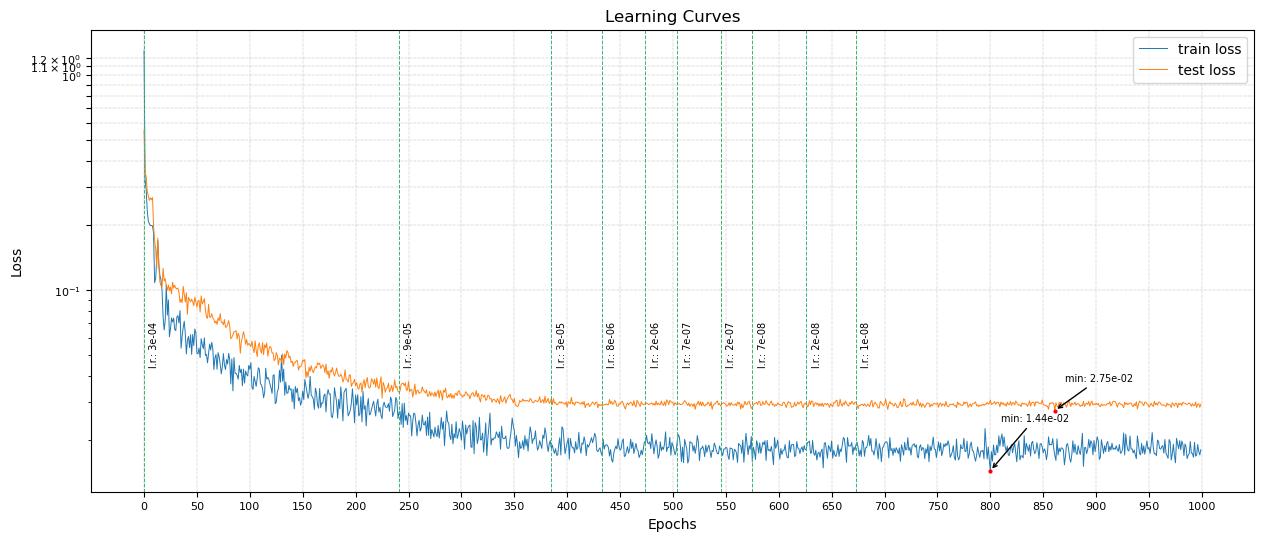

In [109]:
plot_learning_curves(history)

### Load the model with lowest loss

In [ ]:
# Load the model with lowest loss
from tensorflow import keras
vae = keras.models.load_model(checkpoint_filepath)

## Show Grid of Reconstrutions

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the number of rows and columns in the grid
num_rows = 2
num_cols = 8

# Generate random samples for the latent space
z_samples = np.random.rand(1, ARGS["LATENT_DIM"])

# Define the frames to display
frames_num = [0, 2800, 5500, 8500, 11000, 14000, 17000, 22500]
# divide each element of frames_num by 100
idx = list(np.divide(frames_num, 100).astype(int))
imgs_paths = glob(os.path.join(TRAIN_DIR, "*.png"))
images = list()
# load images with index = idx
for i in range(len(idx)):
    img = load_img(imgs_paths[idx[i]], color_mode="grayscale")
    img_array = img_to_array(img) / 255.0
    images.append(img_array)
# convert list to float32 array
imgs_array = np.array(images, dtype=np.float32)

# Initialize the plot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 4))
# figure size

fig.set_figwidth(25)
fig.set_figheight(7)

# Loop through each row and column in the grid
for j in range(num_cols):

    # Get the frame to display
    frame_num = frames_num[j]
    
    # Get the reconstructed image
    z_sample = np.random.rand(1, ARGS["LATENT_DIM"])
    # array of shape (1, ARGS["LATENT_DIM"]) with 0.5 values
    #z_sample = np.full((1, ARGS["LATENT_DIM"]), 0)
    reconst = decoder.predict([z_sample, frame_to_label(frame_num)])
    reconst = reconst.reshape(512, 512)
    
    # Display the ground truth mask and the reconstructed mask
    axes[0][j].imshow(imgs_array[j], cmap='Greys_r')
    axes[0][j].set_title(f"U-NET Seg. {frame_num}")
    axes[1][j].imshow(reconst, cmap='viridis')
    axes[1][j].set_title(f"C-VAE Reconstrution {frame_num}")
    axes[1][j].set_axis_off()
    axes[0][j].set_axis_off()
    
# Display the plot
plt.show()

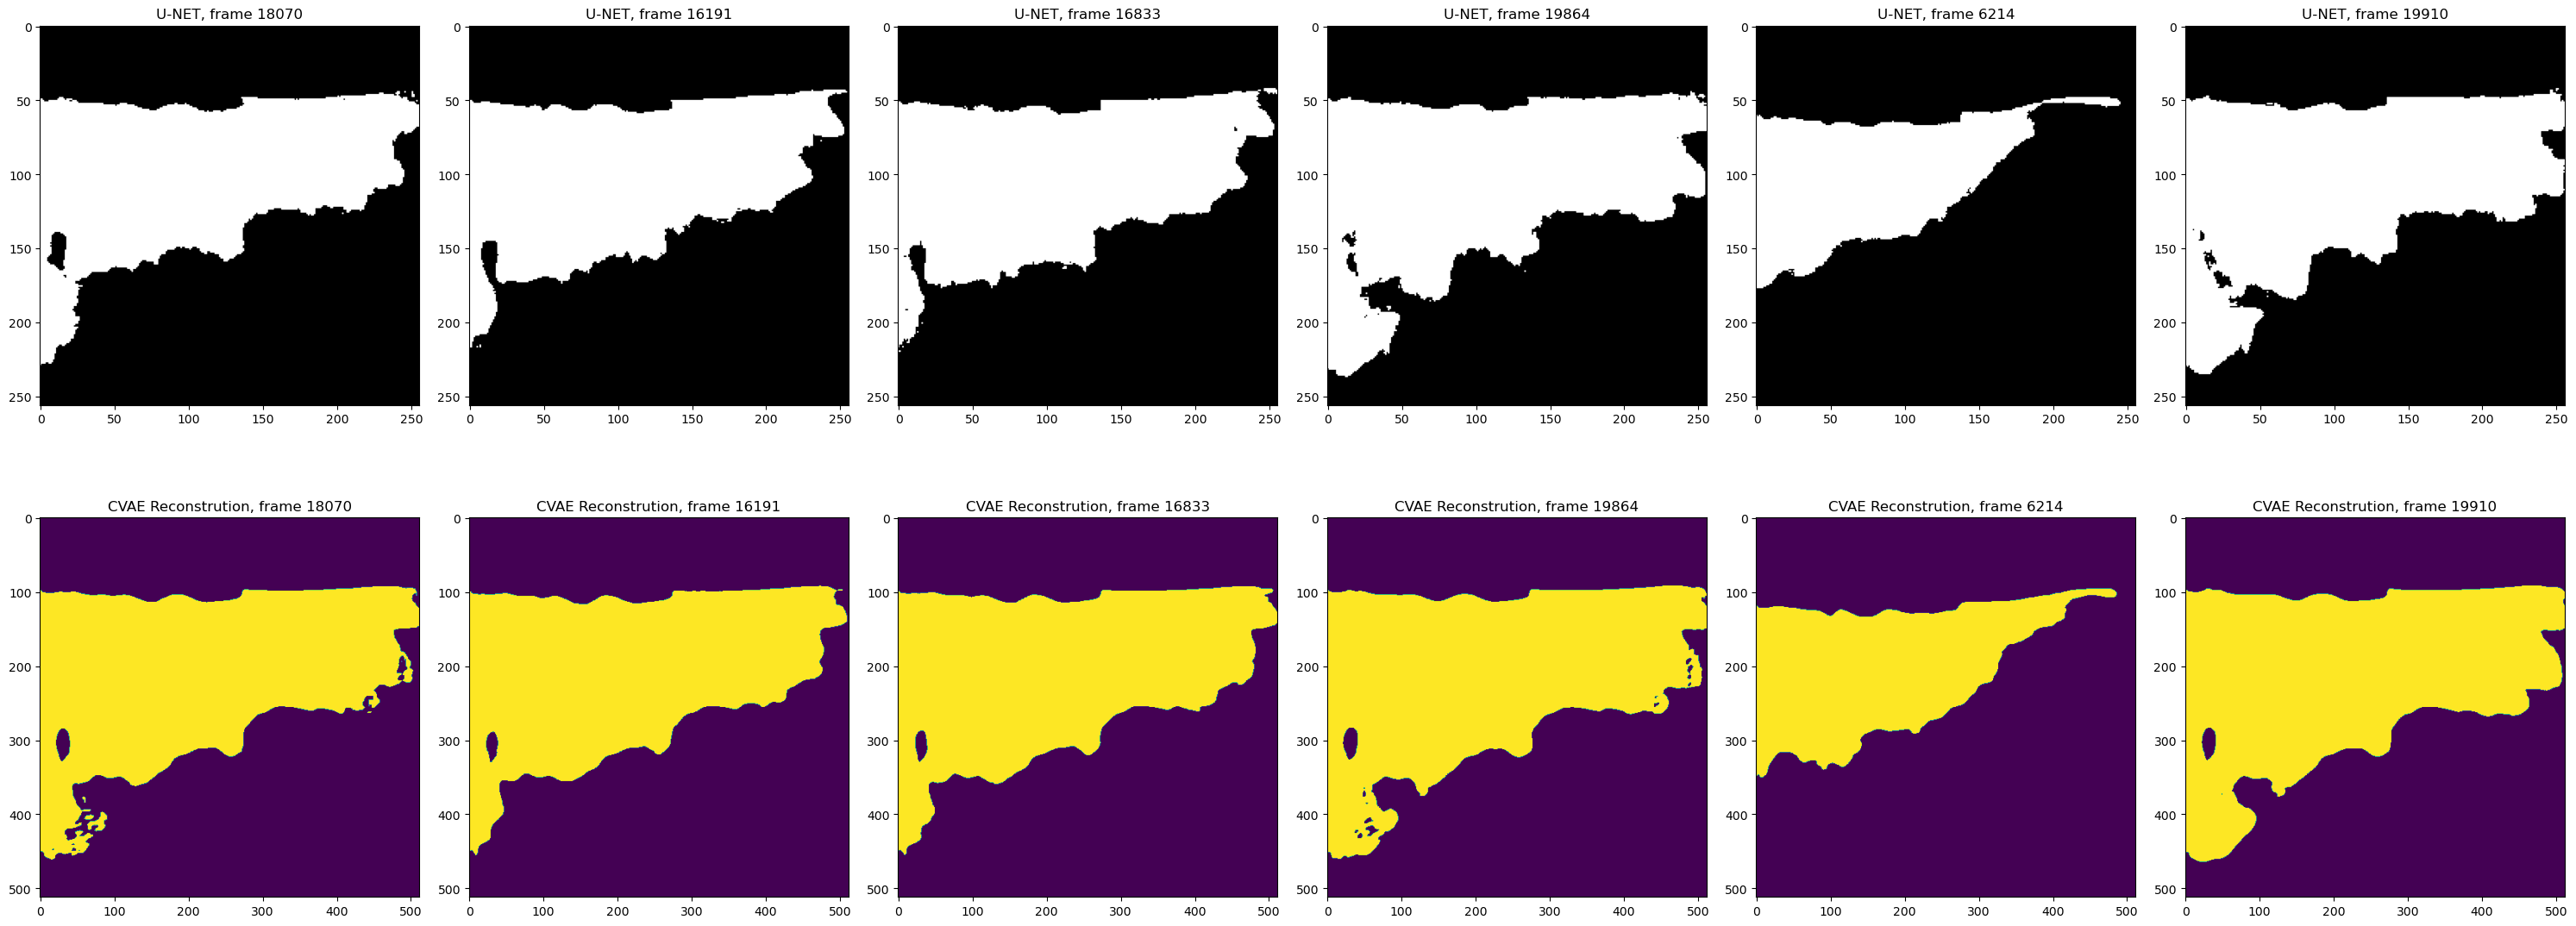

In [111]:
segs_base = glob(os.path.join(IMG_DIR, "segs_base", "*.png"))

# random sample array of frames
frames_num = np.random.randint(0, 22500, 6)
# Initialize the plot
fig, axes = plt.subplots(2,len(frames_num), figsize=(10, 3))
# figure size
fig.set_figwidth(5*len(frames_num))
fig.set_figheight(12)

for j in range(len(frames_num)):

    # Get the frame to display
    frame_num = frames_num[j]
    
    # Get the reconstructed image
    z_sample = np.random.rand(1, ARGS["LATENT_DIM"])
    reconst = decoder.predict([z_sample, frame_to_label(frame_num)])
    reconst = reconst.reshape(512, 512)
    # binarize the reconstructed image
    ret, thresh_img = cv2.threshold(reconst,0.5, 255,  cv2.THRESH_BINARY)
                                
    axes[0][j].imshow(load_img(segs_base[frame_num], color_mode="grayscale"), cmap='Greys_r')
    axes[0][j].set_title(f"U-NET, frame {frame_num}")

    # Display the ground truth mask and the reconstructed mask
    axes[1][j].imshow(thresh_img, cmap='viridis')
    axes[1][j].set_title(f"CVAE Reconstrution, frame {frame_num}")

# Display the plot
plt.tight_layout()
plt.show()

#### Output files (various folders for various experiments)

In [22]:
frames_num = np.arange(0, 22500, 1)
# images directories
CVAE_DIR = os.path.normpath("E:\BurnedAreaUAV_files\Interpolation\cvae_interpol")
CVAE_PNG_DIR = os.path.join(CVAE_DIR, "PNGs")
CVAE_256_PNG_DIR = os.path.join(CVAE_DIR, "PNGs_256")
CVAE_PNG_DIR_CE = os.path.join(CVAE_DIR, "PNGs_celoss")
CVAE_PNG_DIR_SAMPLED = os.path.join(CVAE_DIR, "PNGs_sampled")
os.makedirs(CVAE_PNG_DIR_SAMPLED, exist_ok=True)

# WKT files
CVAE_WKT_FILE = os.path.join(CVAE_DIR, "cvae_interpol.wkt")
CVAE_WKT_FILE_256 = os.path.join(CVAE_DIR, "cvae_interpol_256.wkt")
CVAE_WKT_FILE_CE = os.path.join(CVAE_DIR, "cvae_interpol_ce.wkt")
CVAE_WKT_FILE_SAMPLED = os.path.join(CVAE_DIR, "cvae_interpol_sampled.wkt")

## Inference

In [ ]:
from matplotlib import cm
# create binary, black or white colormap
cmap_B_W = cm.get_cmap('gray', 2)

# generate all the frames and save the images as png
for i in range(len(frames_num)):
    frame_num = frames_num[i]
    # z_sample = np.random.rand(1, ARGS["LATENT_DIM"])
    z_sample = np.full((1, ARGS["LATENT_DIM"]), 0.5)
    reconst = decoder.predict([z_sample, frame_to_label(frame_num)])
    reconst = reconst.reshape(ARGS["IMG_SIZE"])
    # binarize the reconstructed image
    ret, thresh_img = cv2.threshold(reconst, 0.5, 255, cv2.THRESH_BINARY)
    # image resize cv2.INTER_CUBIC
    reconst = cv2.resize(thresh_img, (ORIG_DIMS[1], ORIG_DIMS[0]), interpolation=cv2.INTER_CUBIC)
    # save the image as png grayscale
    imsave(os.path.join(CVAE_PNG_DIR_SAMPLED, f"frame_{frame_num:06d}.png"), reconst, cmap = cmap_B_W)
    # print progress
    print(f"frames {i+1}/{frames_num[-1]+1} saved", end="\r")

#### frames to video conversion

In [23]:
# list of ordered frames
frames = sorted(glob(os.path.join(CVAE_PNG_DIR_SAMPLED, "*.png")))

# create the video
frames2video(frames, "cvae_interpol_512_sampled", fps_ = 25*10, 
             titulo = "CVAE Interpolation - Sampled (10x speed)", 
             frame_num_text = True)

2. Creating video writer...2501


#### WKT output file

In [24]:
polygon_list = msks_paths_to_polygon_list(frames, out_dim = (1280, 720))

In [26]:
# Convert shapely list polygons to WKT format file
with open(CVAE_WKT_FILE_SAMPLED, 'w') as f:
    for polygon in polygon_list:
        f.write(polygon.wkt + '\n')